In [1]:
# !pip install -U transformers accelerate datasets git+https://github.com/huggingface/diffusers Pillow==9.4.0 torchmetrics wandb

In [2]:
# from local_secrets import hf_token, wandb_key
# from huggingface_hub import login
# import wandb

# login(token=hf_token)
# wandb.login(key=wandb_key)

In [3]:
import torch, torch.nn.functional as F, random, wandb, time
import torchvision.transforms as T
from torchvision import transforms
from diffusers import AutoencoderDC, SanaTransformer2DModel
from diffusers.schedulers import FlowMatchEulerDiscreteScheduler
from transformers import AutoModel, AutoTokenizer, set_seed
from datasets import load_dataset, Dataset, DatasetDict
from tqdm import tqdm
from torch.utils.data import DataLoader

from utils import PIL_to_latent, latent_to_PIL, make_grid, encode_prompt, dcae_scalingf, pil_clipscore
from utils import cifar10_labels

seed = 42
set_seed(seed)

In [4]:
dtype = torch.bfloat16
device = "cuda" if torch.cuda.is_available() else "mps" if torch.mps.is_available() else "cpu"

transformer = SanaTransformer2DModel.from_config("transformer_Sana-7L-MBERT_config.json").to(device).to(dtype)
text_encoder = AutoModel.from_pretrained("answerdotai/ModernBERT-base", torch_dtype=dtype).to(device)
tokenizer = AutoTokenizer.from_pretrained("answerdotai/ModernBERT-base", torch_dtype=dtype)

model = "Efficient-Large-Model/Sana_600M_1024px_diffusers"
dcae = AutoencoderDC.from_pretrained(model, subfolder="vae", torch_dtype=dtype).to(device)
# scheduler = FlowMatchEulerDiscreteScheduler.from_pretrained(model, subfolder="scheduler")

/home/g/.local/lib/python3.10/site-packages/diffusers/configuration_utils.py:245: FutureWarning: It is deprecated to pass a pretrained model name or path to `from_config`.If you were trying to load a model, please use <class 'diffusers.models.transformers.sana_transformer.SanaTransformer2DModel'>.load_config(...) followed by <class 'diffusers.models.transformers.sana_transformer.SanaTransformer2DModel'>.from_config(...) instead. Otherwise, please make sure to pass a configuration dictionary instead. This functionality will be removed in v1.0.0.
  deprecate("config-passed-as-path", "1.0.0", deprecation_message, standard_warn=False)
You are attempting to use Flash Attention 2.0 with a model not initialized on GPU. Make sure to move the model to GPU after initializing it on CPU with `model.to('cuda')`.


# Load dataset

In [5]:
ds = load_dataset("g-ronimo/CIFAR10-64-latents_dc-ae-f32c32-sana-1.0")
ds["train"]

Dataset({
    features: ['label', 'latent'],
    num_rows: 50000
})

In [6]:
labels = cifar10_labels
labels_encoded={k: encode_prompt(labels[k], tokenizer, text_encoder) for k in labels}

len(labels_encoded), len(labels_encoded[0]), labels_encoded[0][0].shape, labels_encoded[0][1].shape

(10, 2, torch.Size([1, 300, 768]), torch.Size([1, 300]))

In [7]:
from torch.utils.data import DataLoader

def collate(items):
    labels = [i["label"] for i in items]
    latents = torch.cat([torch.Tensor(i["latent"]) for i in items]).to(dtype).to(device)
    prompts_encoded = torch.cat([labels_encoded[label][0] for label in labels])
    prompts_atnmask = torch.cat([labels_encoded[label][1] for label in labels])

    return labels, latents, prompts_encoded, prompts_atnmask

dataloader = DataLoader(ds["train"], batch_size=2, shuffle=True, generator = torch.manual_seed(seed), collate_fn=collate)
labels, latents, prompts_encoded, prompts_atnmask = next(iter(dataloader))
len(labels), latents.mean(), latents.shape, prompts_encoded.shape, prompts_atnmask.shape

(2,
 tensor(-0.0366, device='cuda:0', dtype=torch.bfloat16),
 torch.Size([2, 32, 2, 2]),
 torch.Size([2, 300, 768]),
 torch.Size([2, 300]))

In [8]:
# # create a test batch
# testbatch = []
# seen = {}

# for i in range(100):
#     item = ds["train"][i]
#     label, latent = item["label"], item["latent"]
#     if not label in seen:
#         print("Adding ", label)
#         seen[label] = True
#         testbatch.append(item)
#     if len(testbatch) == 10: break
# testbatch = collate(testbatch)

In [9]:
# labels, latents, prompts_encoded, prompts_atnmask = testbatch

# print(labels)
# latents_decoded = [latent_to_PIL(latents[i,None], dcae) for i in range(len(labels))]
# display(make_grid(latents_decoded, 2, 5).resize((800,300)))


# Helpers for eval and generate

In [10]:
def get_timesteps(num_steps):
    dt = 1.0 / num_steps
    timesteps = [int(i/num_steps*1000) for i in range(num_steps, 0, -1)]
    return dt, timesteps
get_timesteps(3)

(0.3333333333333333, [1000, 666, 333])

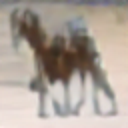

In [231]:
def generate(prompt, latent_dim=[1, 32, 2, 2], num_steps=100, latent_seed=42):
    dt, timesteps = get_timesteps(num_steps)
    # print(timesteps)
    prompt_encoded, prompt_atnmask = encode_prompt(prompt, tokenizer, text_encoder)
    latent = torch.randn(latent_dim, generator = torch.manual_seed(latent_seed)).to(dtype).to(device)
    for t in timesteps:
        t = torch.Tensor([t]).to(dtype).to(device)
        with torch.no_grad():
            noise_pred = transformer(latent, encoder_hidden_states=prompt_encoded, timestep=t, encoder_attention_mask=prompt_atnmask, return_dict=False)[0]
        latent = latent - dt * noise_pred

    return latent_to_PIL(latent, dcae)

generate("horse", num_steps=10, latent_seed=43).resize((128,128))

100%|█████████████████████████████████████████████| 4/4 [00:02<00:00,  1.44it/s]


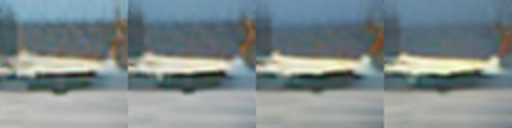

In [254]:
images = [generate("airplane", num_steps=steps, latent_seed=45) for steps in tqdm([10, 20, 100, 200])]
make_grid(images, 1, len(images)).resize((128*len(images), 128))

In [12]:
# def eval_loss(data_val, num_samples=10, batch_size=24):
#     losses = []
#     eval_dataloader = iter(DataLoader(data_val, batch_size=batch_size, shuffle=False, collate_fn=collate))
    
#     for i in tqdm(range(num_samples), "eval_loss"):
#         label, latent, prompt_encoded, prompt_atnmask = next(eval_dataloader)
#         noise = torch.randn_like(latent)
#         timestep = scheduler.timesteps[torch.randint(scheduler.timesteps.size(0),(latent.shape[0],))].to(device)
#         latent_noisy = scheduler.scale_noise(latent, timestep, noise)
#         with torch.no_grad():
#             noise_pred = transformer(latent_noisy, encoder_hidden_states = prompt_encoded, encoder_attention_mask = prompt_atnmask, timestep = timestep, return_dict=False)[0]
#         loss = F.mse_loss(noise_pred, noise - latent)
#         losses.append(loss.item())
#     return sum(losses)/len(losses)

# eval_loss(ds["train"])

In [13]:
def eval_clipscore(images):
    prompts = [cifar10_labels[k] for k in cifar10_labels]
    return pil_clipscore(images, prompts)

images = [generate(p) for p in tqdm([cifar10_labels[k] for k in cifar10_labels], "eval_images")]
eval_clipscore(images)

eval_images: 100%|██████████████████████████████| 10/10 [00:08<00:00,  1.15it/s]


23.43852424621582

# Train

In [14]:
log_wandb = True
lr = 5e-4
# bs = 64
bs = 896
epochs = 500
timesteps_training = 1000
steps_log, steps_eval = 10, 200
# steps_log, steps_eval = 10, 20

splits = list(ds.keys())
data_train, data_val = ds[splits[0]], ds[splits[1]]

steps_epoch = len(data_train) // bs

dataloader = DataLoader(data_train, batch_size=bs, shuffle=True, generator = torch.manual_seed(seed), collate_fn=collate)
optimizer = torch.optim.AdamW(transformer.parameters(), lr=lr)

model_size = sum(p.numel() for p in transformer.parameters() if p.requires_grad)
print(f"Model parameters: {model_size / 1e6:.2f}M")
print(f"{len(splits)} splits: {splits}", [len(ds[s]) for s in splits])
assert len(splits)==2 

Model parameters: 156.41M
2 splits: ['train', 'test'] [50000, 10000]


In [ ]:
if log_wandb: 
    if wandb.run is not None: wandb.finish()
    wandb.init(project="Hana", name=f"Z-{model_size / 1e6:.2f}M_CIFAR10_LR-{lr}_BS-{bs}_TS-{timesteps_training}_my3090").log_code(".", include_fn=lambda path: path.endswith(".py") or path.endswith(".ipynb") or path.endswith(".json"))

step = 0
last_step_time = time.time()

for _ in range(epochs):
    for labels, latents, prompts_encoded, prompts_atnmask in dataloader:
        noise = torch.randn_like(latents)
        t = torch.randint(1, timesteps_training + 1, (latents.size(0),)).to(device)
        tperc = t.view([latents.size(0), *([1] * len(latents.shape[1:]))])/timesteps_training
        latents_noisy = (1 - tperc) * latents + tperc * noise # (1-noise_level) * latent + noise_level * noise
        noise_pred = transformer(latents_noisy.to(dtype), prompts_encoded, t, prompts_atnmask).sample
    
        loss = F.mse_loss(noise_pred, noise - latents)
        loss.backward()
        grad_norm = torch.nn.utils.clip_grad_norm_(transformer.parameters(), 1.0)
        optimizer.step()
        optimizer.zero_grad()    
        
        if step % steps_log == 0:
            loss_train = loss.item()
            step_time = (time.time() - last_step_time) / steps_log * 1000
            sample_tp = bs * steps_log / (time.time() - last_step_time)
            print(f"step {step}, epoch: {step / steps_epoch:.4f}, train loss: {loss_train:.4f}, grad_norm: {grad_norm:.2f}, {step_time:.2f}ms/step, {sample_tp:.2f}samples/sec")
            if log_wandb: wandb.log({"loss_train": loss_train, "grad_norm": grad_norm, "step_time": step_time, "step": step, "sample_tp": sample_tp, "sample_count": step * bs, "epoch": step / steps_epoch})
            last_step_time = time.time()
    
        if step % steps_eval == 0:
            transformer.eval()
            # loss_eval = eval_loss(data_val)
            images_eval = [generate(p) for p in tqdm([cifar10_labels[k] for k in cifar10_labels], "eval_images")]
            clipscore = eval_clipscore(images_eval)
            print(f"step {step}, clipscore: {clipscore:.2f}")
            if log_wandb: wandb.log({"clipscore": clipscore, "images_eval": wandb.Image(make_grid(images_eval, 2, 5)), "step": step, "sample_count": step * bs, "epoch": step / steps_epoch})
            # print(f"step {step}, eval loss: {loss_eval:.4f}, clipscore: {clipscore:.2f}")
            # if log_wandb: wandb.log({"loss_eval": loss_eval, "clipscore": clipscore, "images_eval": wandb.Image(make_grid(images_eval, 2, 5)), "step": step, "sample_count": step * bs, "epoch": step / steps_epoch})
            transformer.train()
        step += 1

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: g-ronimo to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


step 0, epoch: 0.0000, train loss: 6.5938, grad_norm: 14.25, 127.55ms/step, 7024.67samples/sec


eval_images: 100%|██████████████████████████████| 10/10 [00:08<00:00,  1.16it/s]


step 0, clipscore: 23.45
step 10, epoch: 0.1818, train loss: 5.2500, grad_norm: 3.28, 2238.61ms/step, 400.25samples/sec
step 20, epoch: 0.3636, train loss: 4.2188, grad_norm: 2.66, 1000.43ms/step, 895.62samples/sec
step 30, epoch: 0.5455, train loss: 3.5469, grad_norm: 2.02, 1013.05ms/step, 884.46samples/sec
step 40, epoch: 0.7273, train loss: 3.3906, grad_norm: 2.27, 976.04ms/step, 917.99samples/sec
step 50, epoch: 0.9091, train loss: 3.1719, grad_norm: 1.68, 976.01ms/step, 918.02samples/sec
step 60, epoch: 1.0909, train loss: 3.1094, grad_norm: 1.47, 990.78ms/step, 904.33samples/sec
step 70, epoch: 1.2727, train loss: 3.2031, grad_norm: 1.91, 1009.27ms/step, 887.77samples/sec
step 80, epoch: 1.4545, train loss: 3.0938, grad_norm: 1.64, 976.00ms/step, 918.04samples/sec
step 90, epoch: 1.6364, train loss: 3.0938, grad_norm: 1.16, 1011.04ms/step, 886.21samples/sec
step 100, epoch: 1.8182, train loss: 3.0156, grad_norm: 1.27, 977.34ms/step, 916.77samples/sec
step 110, epoch: 2.0000, trai

eval_images: 100%|██████████████████████████████| 10/10 [00:08<00:00,  1.22it/s]


step 200, clipscore: 23.39
step 210, epoch: 3.8182, train loss: 3.0938, grad_norm: 0.96, 4110.64ms/step, 217.97samples/sec
step 220, epoch: 4.0000, train loss: 3.0469, grad_norm: 0.78, 1003.15ms/step, 893.19samples/sec
step 230, epoch: 4.1818, train loss: 2.9219, grad_norm: 0.85, 984.18ms/step, 910.40samples/sec
step 240, epoch: 4.3636, train loss: 2.9844, grad_norm: 0.83, 1048.22ms/step, 854.78samples/sec
step 250, epoch: 4.5455, train loss: 2.9688, grad_norm: 0.82, 1006.24ms/step, 890.44samples/sec
step 260, epoch: 4.7273, train loss: 2.8906, grad_norm: 0.79, 1003.49ms/step, 892.88samples/sec
step 270, epoch: 4.9091, train loss: 2.9844, grad_norm: 0.80, 1049.78ms/step, 853.51samples/sec
step 280, epoch: 5.0909, train loss: 2.9062, grad_norm: 0.82, 996.70ms/step, 898.97samples/sec
step 290, epoch: 5.2727, train loss: 2.9375, grad_norm: 0.68, 1006.19ms/step, 890.49samples/sec
step 300, epoch: 5.4545, train loss: 2.9062, grad_norm: 0.68, 1015.29ms/step, 882.51samples/sec
step 310, epoch

eval_images: 100%|██████████████████████████████| 10/10 [00:08<00:00,  1.20it/s]


step 400, clipscore: 23.57
step 410, epoch: 7.4545, train loss: 2.9844, grad_norm: 0.61, 2108.14ms/step, 425.02samples/sec
step 420, epoch: 7.6364, train loss: 2.9844, grad_norm: 0.56, 1045.63ms/step, 856.90samples/sec
step 430, epoch: 7.8182, train loss: 2.9219, grad_norm: 0.63, 1005.56ms/step, 891.04samples/sec
step 440, epoch: 8.0000, train loss: 2.9688, grad_norm: 0.68, 1056.03ms/step, 848.46samples/sec
step 450, epoch: 8.1818, train loss: 2.8594, grad_norm: 0.55, 985.44ms/step, 909.24samples/sec
step 460, epoch: 8.3636, train loss: 2.8594, grad_norm: 0.65, 982.75ms/step, 911.72samples/sec
step 470, epoch: 8.5455, train loss: 2.9531, grad_norm: 0.62, 1014.62ms/step, 883.09samples/sec
step 480, epoch: 8.7273, train loss: 2.8594, grad_norm: 0.70, 1000.54ms/step, 895.52samples/sec
step 490, epoch: 8.9091, train loss: 2.8906, grad_norm: 0.63, 1009.00ms/step, 888.00samples/sec
step 500, epoch: 9.0909, train loss: 2.8750, grad_norm: 0.55, 1052.04ms/step, 851.67samples/sec
step 510, epoch

eval_images: 100%|██████████████████████████████| 10/10 [00:08<00:00,  1.22it/s]


step 600, clipscore: 23.85
step 610, epoch: 11.0909, train loss: 2.9844, grad_norm: 0.64, 2101.16ms/step, 426.43samples/sec
step 620, epoch: 11.2727, train loss: 2.8281, grad_norm: 0.56, 994.50ms/step, 900.95samples/sec
step 630, epoch: 11.4545, train loss: 2.8438, grad_norm: 0.64, 1003.99ms/step, 892.44samples/sec
step 640, epoch: 11.6364, train loss: 2.8750, grad_norm: 0.71, 1048.20ms/step, 854.80samples/sec
step 650, epoch: 11.8182, train loss: 2.8438, grad_norm: 0.50, 1007.08ms/step, 889.70samples/sec
step 660, epoch: 12.0000, train loss: 2.8438, grad_norm: 0.53, 1007.70ms/step, 889.16samples/sec
step 670, epoch: 12.1818, train loss: 2.8906, grad_norm: 0.58, 1048.63ms/step, 854.45samples/sec
step 680, epoch: 12.3636, train loss: 2.8438, grad_norm: 0.54, 985.72ms/step, 908.98samples/sec
step 690, epoch: 12.5455, train loss: 2.9062, grad_norm: 0.51, 1006.50ms/step, 890.22samples/sec
step 700, epoch: 12.7273, train loss: 2.8438, grad_norm: 0.55, 1049.36ms/step, 853.85samples/sec
step 

eval_images: 100%|██████████████████████████████| 10/10 [00:08<00:00,  1.20it/s]


step 800, clipscore: 23.41
step 810, epoch: 14.7273, train loss: 2.9844, grad_norm: 0.57, 2573.37ms/step, 348.18samples/sec
step 820, epoch: 14.9091, train loss: 2.9375, grad_norm: 0.52, 1003.00ms/step, 893.32samples/sec
step 830, epoch: 15.0909, train loss: 2.9062, grad_norm: 0.61, 1002.84ms/step, 893.46samples/sec
step 840, epoch: 15.2727, train loss: 2.8750, grad_norm: 0.50, 1021.15ms/step, 877.44samples/sec
step 850, epoch: 15.4545, train loss: 2.8594, grad_norm: 0.52, 1045.04ms/step, 857.38samples/sec
step 860, epoch: 15.6364, train loss: 2.8125, grad_norm: 0.55, 1005.95ms/step, 890.70samples/sec
step 870, epoch: 15.8182, train loss: 2.8906, grad_norm: 0.54, 1047.86ms/step, 855.07samples/sec
step 880, epoch: 16.0000, train loss: 2.8281, grad_norm: 0.57, 1006.61ms/step, 890.11samples/sec
step 890, epoch: 16.1818, train loss: 2.8594, grad_norm: 0.49, 1048.75ms/step, 854.35samples/sec
step 900, epoch: 16.3636, train loss: 2.8281, grad_norm: 0.49, 996.51ms/step, 899.14samples/sec
step

eval_images: 100%|██████████████████████████████| 10/10 [00:08<00:00,  1.22it/s]


step 1000, clipscore: 23.23
step 1010, epoch: 18.3636, train loss: 2.8438, grad_norm: 0.63, 2146.20ms/step, 417.48samples/sec
step 1020, epoch: 18.5455, train loss: 2.8438, grad_norm: 0.59, 1004.66ms/step, 891.84samples/sec
step 1030, epoch: 18.7273, train loss: 2.7969, grad_norm: 0.52, 1004.10ms/step, 892.34samples/sec
step 1040, epoch: 18.9091, train loss: 2.8281, grad_norm: 0.44, 1047.48ms/step, 855.39samples/sec
step 1050, epoch: 19.0909, train loss: 2.8281, grad_norm: 0.48, 1007.25ms/step, 889.55samples/sec
step 1060, epoch: 19.2727, train loss: 2.7969, grad_norm: 0.46, 1005.83ms/step, 890.80samples/sec
step 1070, epoch: 19.4545, train loss: 2.7969, grad_norm: 0.48, 995.31ms/step, 900.22samples/sec
step 1080, epoch: 19.6364, train loss: 2.8125, grad_norm: 0.52, 1004.73ms/step, 891.78samples/sec
step 1090, epoch: 19.8182, train loss: 2.8438, grad_norm: 0.47, 1006.26ms/step, 890.42samples/sec
step 1100, epoch: 20.0000, train loss: 2.8125, grad_norm: 0.42, 1047.86ms/step, 855.07sampl

eval_images: 100%|██████████████████████████████| 10/10 [00:08<00:00,  1.21it/s]


step 1200, clipscore: 23.11
step 1210, epoch: 22.0000, train loss: 2.9219, grad_norm: 0.48, 2121.08ms/step, 422.43samples/sec
step 1220, epoch: 22.1818, train loss: 2.8594, grad_norm: 0.47, 1048.49ms/step, 854.56samples/sec
step 1230, epoch: 22.3636, train loss: 2.8438, grad_norm: 0.52, 1008.49ms/step, 888.46samples/sec
step 1240, epoch: 22.5455, train loss: 2.8906, grad_norm: 0.48, 983.69ms/step, 910.86samples/sec
step 1250, epoch: 22.7273, train loss: 2.8125, grad_norm: 0.53, 1050.38ms/step, 853.02samples/sec
step 1260, epoch: 22.9091, train loss: 2.7656, grad_norm: 0.43, 1009.43ms/step, 887.63samples/sec
step 1270, epoch: 23.0909, train loss: 2.8125, grad_norm: 0.51, 1009.82ms/step, 887.29samples/sec
step 1280, epoch: 23.2727, train loss: 2.7812, grad_norm: 0.48, 1053.57ms/step, 850.45samples/sec
step 1290, epoch: 23.4545, train loss: 2.8281, grad_norm: 0.52, 991.96ms/step, 903.26samples/sec
step 1300, epoch: 23.6364, train loss: 2.8281, grad_norm: 0.46, 1010.78ms/step, 886.44sample

In [251]:
transformer.push_to_hub(f"g-ronimo/hana-alpha12_cifar10_TS-{timesteps_training}_{epochs}e")

diffusion_pytorch_model.safetensors:   0%|          | 0.00/313M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/g-ronimo/hana-alpha12_cifar10_TS-1000_500e/commit/eccd5612852d24288540edaf0b2254d21fc8f45c', commit_message='Upload model', commit_description='', oid='eccd5612852d24288540edaf0b2254d21fc8f45c', pr_url=None, repo_url=RepoUrl('https://huggingface.co/g-ronimo/hana-alpha12_cifar10_TS-1000_500e', endpoint='https://huggingface.co', repo_type='model', repo_id='g-ronimo/hana-alpha12_cifar10_TS-1000_500e'), pr_revision=None, pr_num=None)

In [ ]:
# !runpodctl remove pod $RUNPOD_POD_ID

100%|███████████████████████████████████████████| 10/10 [01:29<00:00,  8.95s/it]


['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


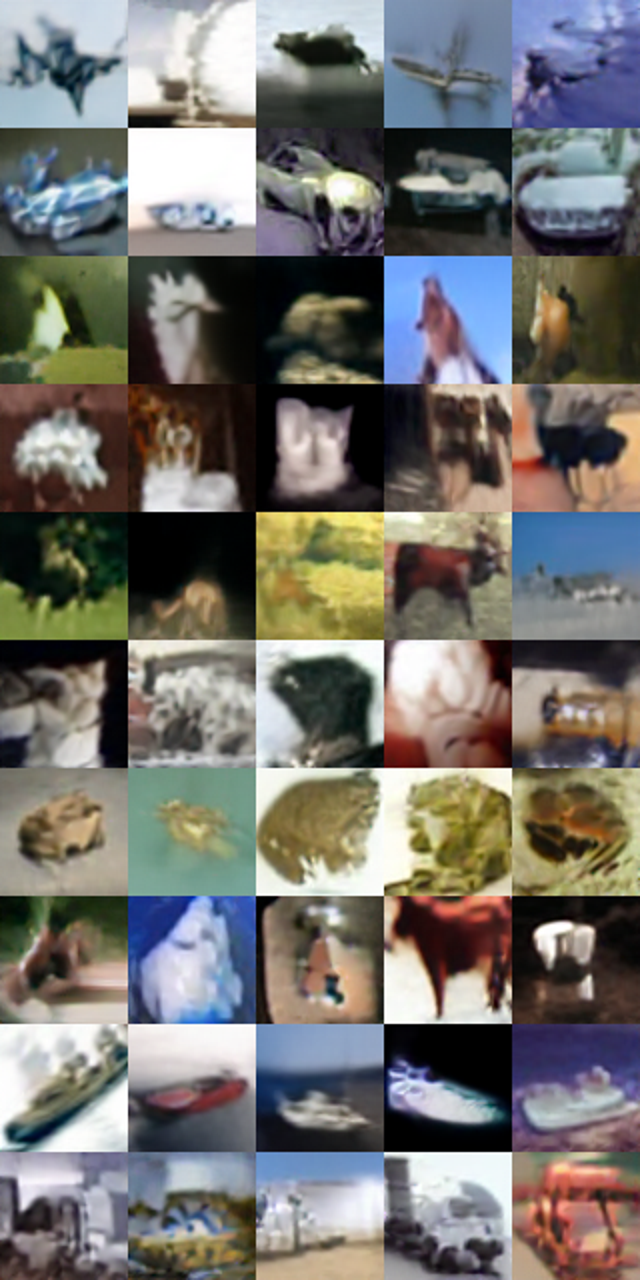

In [250]:
labels = [cifar10_labels[k] for k in cifar10_labels]
num_imgs_per_label = 5
images = [generate(
    label, 
    num_steps=200, 
    latent_seed=random.randint(0,10000)
) for label in tqdm(labels) for _ in range(num_imgs_per_label) ]
print(labels)
make_grid(images, len(labels), num_imgs_per_label).resize((128*num_imgs_per_label, 128*len(labels)))